In [1]:
from plotnine import *
import pandas as pd
import numpy as np

In [2]:
# time = "2024-03-29_04:53"
time = "2024-03-29_07:23"
time = "2024-03-31_15:54"
time = "2024-03-31_16:37"
time = "2024-03-31_17:12"
time = "2024-04-01_15:42"
time = "2024-04-01_17:06"
time = "2024-04-01_18:11"
time = "2024-04-16_16:47"
time = "2024-04-18_19:23"
time = "2024-04-18_20:30"
time = "2024-04-19_01:29"
time = "2024-04-19_09:39"
time = "2024-05-19_16:34"
time = "2024-05-19_16:58"
time = "2024-05-19_17:38"
time = "2024-05-19_18:55"
time = "2024-05-20_04:15"
time = "2024-05-20_10:30"
time = "2024-05-29_13:27"
time = "2024-06-10_12:52" # EUR_USD_M15
time = "2024-06-10_22:59" # USD_JPY_M15
time = "2024-06-11_04:01" # USD_CHF_M15
time = "2024-06-11_04:14" # USD_CAD_M15
time = "2024-06-11_11:42" # AUD_USD_M15
time = "2024-06-11_23:43" # AUD_JPY_M15
time = "2024-06-11_23:48" # AUD_CAD_M15
time = "2024-06-12_08:44" # EUR_JPY_M15
time = "2024-06-12_08:48" # GBP_CHF_M15
time = "2024-06-12_08:52" # GBP_JPY_M15

time = "2024-06-10_19:47" # GBP_USD_M15
time = "2024-08-05_10:02" # GBP_USD_M15


df = pd.read_csv(f"/projects/genomic-ml/da2343/ml_project_2/unsupervised/kmeans/results/{time}_results.csv")

# df['test_cumsum_annualized_return'] = df['test_cumsum_annualized_return'] * -1
# remove where dist_measure is 2
# remove where future_candles is 5
# remove where n_clusters is 150 or 200
# remove where log_return_threshold is greater than 0.01
# remove where calmar_ratio_threshold is not 2

# df = df[df["dist_measure"] != 2]
# df = df[df["window"] < 5]
# df = df[df["random_state"] == 42]
# df = df[df["test_size"] == 2880]
# df = df[df["algorithm"] == "kmeans"]

df = df[(df["test_sharpe_ratio"] >= 0.13) | (df["test_inverse_sharpe_ratio"] >= 0.13)]

# df = df[(df["algorithm"] == 'gaussian_mixture')]
# df = df[(df["max_k_labels"] == 1)]
# df = df[(df["random_state"] == 200)]

df

,window,train_total_annualized_return,train_total_actual_return,train_total_trades,test_total_annualized_return,test_total_actual_return,test_total_trades,train_cumulative_annualized_return,train_cumulative_actual_return,train_sharpe_ratio,test_cumulative_annualized_return,test_cumulative_actual_return,test_sharpe_ratio,test_inverse_sharpe_ratio,max_cluster_labels,num_clusters,clustering_algorithm,train_period,test_period,random_seed
73794,1,0.78,78.0,172,-0.09,-9.0,49,0.78,78.0,4.343059,-0.09,-9.0,0.132742,-0.206408,5,90,kmeans,6,2,7
73795,2,0.82,82.0,179,0.40,40.0,62,1.60,160.0,4.343059,0.31,31.0,0.132742,-0.206408,5,90,kmeans,6,2,7
73796,3,1.01,101.0,232,0.23,23.0,69,2.61,261.0,4.343059,0.54,54.0,0.132742,-0.206408,5,90,kmeans,6,2,7
73797,4,1.27,127.0,207,0.05,5.0,63,3.88,388.0,4.343059,0.59,59.0,0.132742,-0.206408,5,90,kmeans,6,2,7
73798,5,0.89,89.0,186,0.10,10.0,44,4.77,477.0,4.343059,0.69,69.0,0.132742,-0.206408,5,90,kmeans,6,2,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1058213,254,1.86,186.0,449,-0.37,-37.0,113,487.33,48733.0,3.436156,17.44,1744.0,0.133272,-0.178013,5,70,gaussian_mixture,8,2,200
1058214,255,1.63,163.0,424,-0.31,-31.0,112,488.96,48896.0,3.436156,17.13,1713.0,0.133272,-0.178013,5,70,gaussian_mixture,8,2,200
1058215,256,1.19,119.0,404,0.36,36.0,109,490.15,49015.0,3.436156,17.49,1749.0,0.133272,-0.178013,5,70,gaussian_mixture,8,2,200
1058216,257,1.59,159.0,476,0.45,45.0,122,491.74,49174.0,3.436156,17.94,1794.0,0.133272,-0.178013,5,70,gaussian_mixture,8,2,200


Strategy : 1


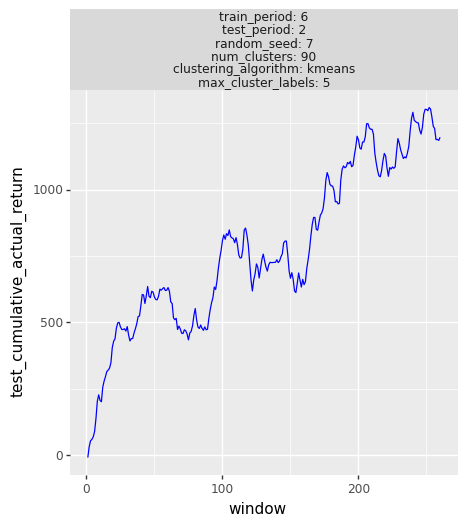


Strategy : 2


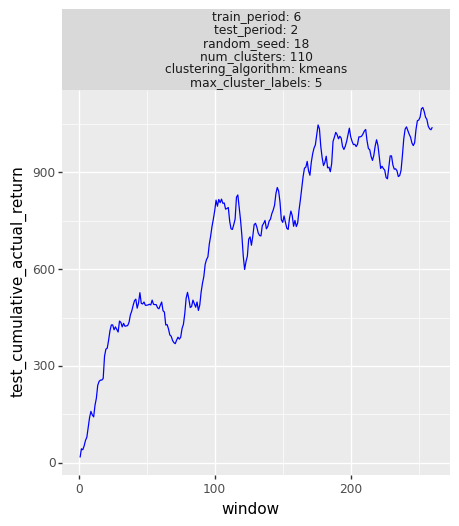


Strategy : 3


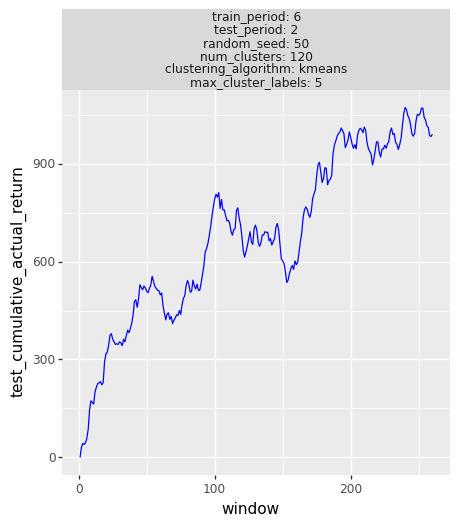


Strategy : 4


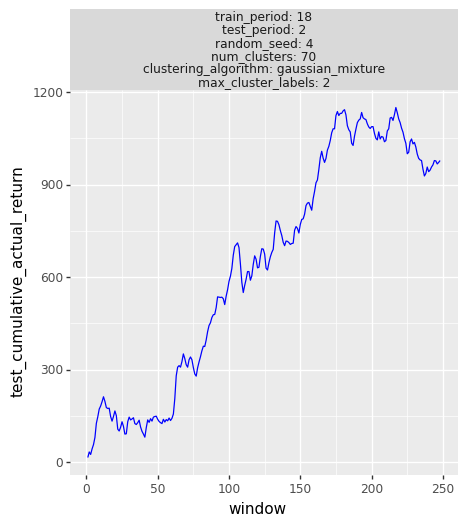

In [8]:
data_dict = {
    "train_period": [6, 6, 6, 18],
    "random_seed": [7, 18, 50, 4],
    "num_clusters": [90, 110, 120, 70],
    "clustering_algorithm": 3 * ["kmeans"] + ["gaussian_mixture"],
    "max_cluster_labels": 3 * [5] + [2],
}
params_concat_df = pd.DataFrame(data_dict)

# remove last row from the dataframe
# params_concat_df = params_concat_df.iloc[:-2]

# loop through the rows of the dataframe
# filter the original dataframe based on the row values
# plot the results
for index, row in params_concat_df.iterrows():
    train_period = row["train_period"]
    random_seed = row["random_seed"]
    num_clusters = row["num_clusters"]
    clustering_algorithm = row["clustering_algorithm"]
    max_cluster_labels = row["max_cluster_labels"]

    filtered_df = df[
        (df["train_period"] == train_period)
        & (df["random_seed"] == random_seed)
        & (df["num_clusters"] == num_clusters)
        & (df["clustering_algorithm"] == clustering_algorithm)
        & (df["max_cluster_labels"] == max_cluster_labels)
    ]
    sub_filtered_df = filtered_df[['window', 'test_total_actual_return', 'test_total_trades']]
    print(f"Strategy : {index + 1}")
    
    p = ggplot(filtered_df)
    p = p + geom_line(aes(x="window", y="test_cumulative_actual_return"), color="blue")
    p = p + facet_wrap("~train_period + test_period + random_seed + num_clusters + clustering_algorithm + max_cluster_labels", scales="free_x", labeller="label_both")
    p = p + theme(figure_size=(5, 5))
    print(p)

In [12]:
import pandas as pd

# Assuming filtered_df is your original dataframe
# Create a copy of the dataframe to ensure we're not working on a slice
sub_filtered_df = filtered_df[['window', 'test_total_actual_return', 'test_total_trades']].copy()

# Create a 'month' column (2 windows = 1 month)
sub_filtered_df['month'] = (sub_filtered_df['window'] - 1) // 2 + 1

# Group by month and calculate monthly totals
monthly_totals = sub_filtered_df.groupby('month').agg({
    'test_total_actual_return': 'sum',
    'test_total_trades': 'sum'
}).reset_index()

# Calculate percentages
monthly_totals['return_percentage'] = monthly_totals['test_total_actual_return'] / monthly_totals['test_total_trades'] * 100

# Merge the monthly percentages back to the dataframe
sub_filtered_df = sub_filtered_df.merge(monthly_totals[['month', 'return_percentage']], on='month', how='left')

# Display the results
print(monthly_totals)
print(sub_filtered_df)

     month  test_total_actual_return  test_total_trades  return_percentage
0        1                      33.0                 63          52.380952
1        2                      10.0                 74          13.513514
2        3                      37.0                 81          45.679012
3        4                      67.0                 75          89.333333
4        5                      35.0                 93          37.634409
..     ...                       ...                ...                ...
119    120                       6.0                118           5.084746
120    121                      15.0                 79          18.987342
121    122                      21.0                 64          32.812500
122    123                     -11.0                 58         -18.965517
123    124                      11.0                 61          18.032787

[124 rows x 4 columns]
     window  test_total_actual_return  test_total_trades  month  \
0        

In [13]:
sub_filtered_df

,window,test_total_actual_return,test_total_trades,month,return_percentage
0,1,15.0,19,1,52.380952
1,2,18.0,44,1,52.380952
2,3,-8.0,36,2,13.513514
3,4,18.0,38,2,13.513514
4,5,14.0,34,3,45.679012
...,...,...,...,...,...
243,244,14.0,28,122,32.812500
244,245,-1.0,30,123,-18.965517
245,246,-10.0,28,123,-18.965517
246,247,5.0,32,124,18.032787


In [ ]:
p = ggplot(df)
p = p + geom_line(aes(x="window", y="test_cumulative_actual_return"), color="blue")
# p = p + geom_line(aes(x="window", y="val_avg_calmar_ratio"), color="red")
# p = p + facet_wrap("~train_period + random_seed", scales="free_x", labeller="label_both")
p = p + facet_wrap("~train_period + test_period + random_seed + num_clusters + clustering_algorithm + max_cluster_labels", scales="free_x", labeller="label_both")
# p = p + theme(figure_size=(35, 35))
p = p + theme(figure_size=(15, 15))
print(p)